# Looping Isochrones Across Multiple Locations
My goal with this exercise was to figure out how to loop through multiple points to create isochrones. I am using a couple test locations from the [NYC Vaccine Location dataset](https://vaccinefinder.nyc.gov/locations), which is the data we are using for the final project. I used the code provided in class for creating isochrones as a base, then streamlined and updated where needed. 

After a LOT of trial and error, I figured out how to use a combination of `for` loops and dictionaries to store and edit multiple dataframes. While this code only deals with five locations, it has the capability to be scaled to a larger dataset. There are some places in the code that could be streamlined and smoothed over, but it works! 

## Initialize Workspace

First, I'll import libraries needed for analysis.

In [1]:
# for data
import pandas as pd

# for spatial data
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# for street network analysis
import osmnx as ox

# for basemaps
import contextily as ctx

Now, I'll upload the location dataset. I manually created this `.csv` dataset by pulling five addresses for vaccine distribution sites and getting the latitute/longitude coordinates for Google maps. For the final project, we have contacted the NYC Open Data project to ask for the shapefile. If they do not respond, then we will figure out how to use the ArcGIS Python API to use the webmap data. The final project may require a few more steps to transform the data into the form need by this code.

In [4]:
# read in the excel spreadsheet
vac = pd.read_excel('data/nyc_vacc.xlsx', sheet_name = "Test")

## Set-Up for Isochrones

The workflow in this section is adapted from the isochrone example notebook provided in class.

### Download and Prep Street Network

For our final project, we might only look at the 20 minute walkshed in order to simplify our analysis. However, for this example, I will follow the workflow to create four walksheds.

In [2]:
# set up variables
network_type = 'walk' # create walkshed
trip_times = [5, 10, 15, 20] # minutes
meters_per_minute = 75 # travel distance per minute

The `place` variable will be a list of lat/lon tuples. This is created by initialize an empty list, the length of `vac` and then looping through each location to assign the lat/lon tuple to the list. 

In [5]:
# create list of tuples for lat/lon

# iniatlize empty list
place = [0]*len(vac)

# loop through lat/lons
for i in range(len(vac)):
    place[i] = (vac.lat[i], vac.lon[i])

I need to download multiple street networks, in order to have one for each point to complete the analysis. I will store the networks in a dictionary and name them G0, G1, G2, etc. I am concerned that this step might take a very long time or break for a larger dataset.

In [6]:
# download multiple street networks into a dictionary using latlon list

# initialize empty dictionary
nets = {}

for i in range(len(vac)):
    name = "G" + str(i) # allows me to dynamically call each dataframe in the dictionary
    nets[name] = ox.graph_from_point(place[i], dist = 2000, network_type=network_type)

### Project Coordinates

Project each of the networks contained in the `nets` dictionary to Web mercator. This step also take some time.

In [7]:
# Project network data to Web Mercator (measurements are in meters)

for i in range(len(vac)):
    name = "G" + str(i)
    nets[name] = ox.project_graph(nets[name], to_crs='epsg:3857')

### Convert Edges and Nodes to Geodataframes

Rather than creating a dataframe for nodes and edges, I will create separate dictionaries called `nodes` and `edges` that contain multiple dataframes (ex. gdf_nodes0, gdf_notes1...) 

In [8]:
# convert nodes and edges to geodataframes stored in dictionaries

# initialize empty dictionaries
nodes = {}
edges = {}

# loop through
for i in range(len(vac)):
    node_name = "gdf_nodes" + str(i)
    edges_name = "gdf_edges" + str(i)
    nodes[node_name], edges[edges_name] = ox.graph_to_gdfs(nets['G' + str(i)]) 
    

### Get Centroids

The centroids will be found for each location and stored in a dictionary.

In [9]:
# initialize dictionaries
minx = {}
miny = {}
maxx = {}
maxy = {}

# loop through for the bounding box coordinates
for i in range(len(vac)):
    name = "gdf_nodes" + str(i)
    minx[name], miny[name], maxx[name], maxy[name] = nodes[name].geometry.total_bounds


In [10]:
# initalize dictionaries
cenx = {}
ceny = {}

# loop through to calculate the centroid
for i in range(len(vac)):
    name = "gdf_nodes" + str(i)
    cenx[name] = (maxx[name]-minx[name])/2 + minx[name]
    ceny[name] = (maxy[name]-miny[name])/2 + miny[name]


### Get Nearest Node to Centroid

Apply the same dictionary loop methodology to get the center node for each location.

In [11]:
cen_node = {}

# use osmnx's get_nearest_node command to get the id for the nearest node
for i in range(len(vac)):
    nets_name = 'G' + str(i)
    cen_name = "gdf_nodes" + str(i)
    
    cen_node[cen_name] = ox.get_nearest_node(nets[nets_name], 
                                  (ceny[cen_name],cenx[cen_name]), 
                                  method = 'euclidean')

## Create Isochrones 

Up to this point, I've used the same methodology to convert the single location code to multiple location code: 
* Create an empty dictionary
* Start `for` loop for the number of locations
* Create a dynamic `name` variable, based on the i location of the loop
* Perform the function by on each dataframe in the dictionary using the dynamic name variable.

This method worked for doing operations on an entire dataframe (such as transforming the coordinate system). However, the following steps require making edits to individual columns within the dataframe. In order to to this, I create a dummy dataframe within the for loop that extracts the ith dataframe, does an operation to that dataframe, and then saves it again in the dictionary. 

### Calculate Travel Costs

In order to add a new column to each of the dataframes in the dictionary, I extract the dataframe `gdf_edgesi` from the `edges` dictionary, assign it to `dummy`, and then add the column. This is a way of directly editing the dataframe within the dictionary.

In [12]:
# create a new column, calculate the time it takes to travel that edge
for i in range(len(vac)):
    name = 'gdf_edges' + str(i)
    dummy = edges[name]
    dummy['walk_time'] = dummy['length']/meters_per_minute

### Choose Colors

Thankfully, these following steps are unchanged from the single location methodology. 

In [14]:
# assign a color hex code for each trip time isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                cmap='cubehelix', 
                                start=0, 
                                return_hex=True)
# reverse order
trip_times.sort(reverse=True)

In [15]:
# create a list of "zipped" time/colors
time_color = list(zip(trip_times, iso_colors))

### Color Nodes Based on Travel Time

This step originally had two nested `for` loops. In this version, I wrap those initial nested `for` loops in an additional `for` loop that goes through each location.

In [16]:
# loop through each trip time and associated color
subgraph = {}

for i in range(len(vac)):
    nets_name = "G" + str(i)
    nodes_name = "gdf_nodes" + str(i)
        
    for time, color in list(time_color):
        # for each trip time, create an egograph of nodes that fall within that distance
        subgraph[nets_name] = nx.ego_graph(nets[nets_name], cen_node[nodes_name], radius=time, distance='time')

        # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
        for node in subgraph[nets_name].nodes():
            nodes[nodes_name].loc[node,'time'] = str(time) + ' mins'
            nodes[nodes_name].loc[node,'color'] = color

In [17]:
# the NaN values then need to be populated with a valid color
for i in range(len(vac)): 
    name = "gdf_nodes" + str(i)
    dummy = nodes[name]
    dummy['color'].fillna('#cccccc', inplace=True)

### Dissolve and Create Convex Hulls

This step dissolves each dataframe in the `nodes` dictionary by time, resulting in four rows. Then a convex hull is created for each of the time categories.

In [18]:
# dissolve the nodes by time
# collapses into a single row based on a certain column and results in multi-point geometry
# this will result in four rows, one for each time category

isochrones = {}

for i in range(len(vac)):
    nodes_name = "gdf_nodes" + str(i)
    dummy = nodes[nodes_name]
    isochrones[nodes_name] = dummy.dissolve("time")


In [19]:
# for each row, create a convex hull

for i in range(len(vac)):
    nodes_name = "gdf_nodes" + str(i)
    dummy = isochrones[nodes_name]
    isochrones[nodes_name] = dummy.convex_hull.reset_index()

In [20]:
# geometry header has been automatically named "0"
# let's rename that

for i in range(len(vac)):
    nodes_name = "gdf_nodes" + str(i)
    dummy = isochrones[nodes_name]
    dummy.columns=['time','geometry']

## Map

I will map each of the locations and their associated walksheds by looping through the dictionaries. By setting `ax.margins()` to zero, the map will zoom to fit all the locations in the window.

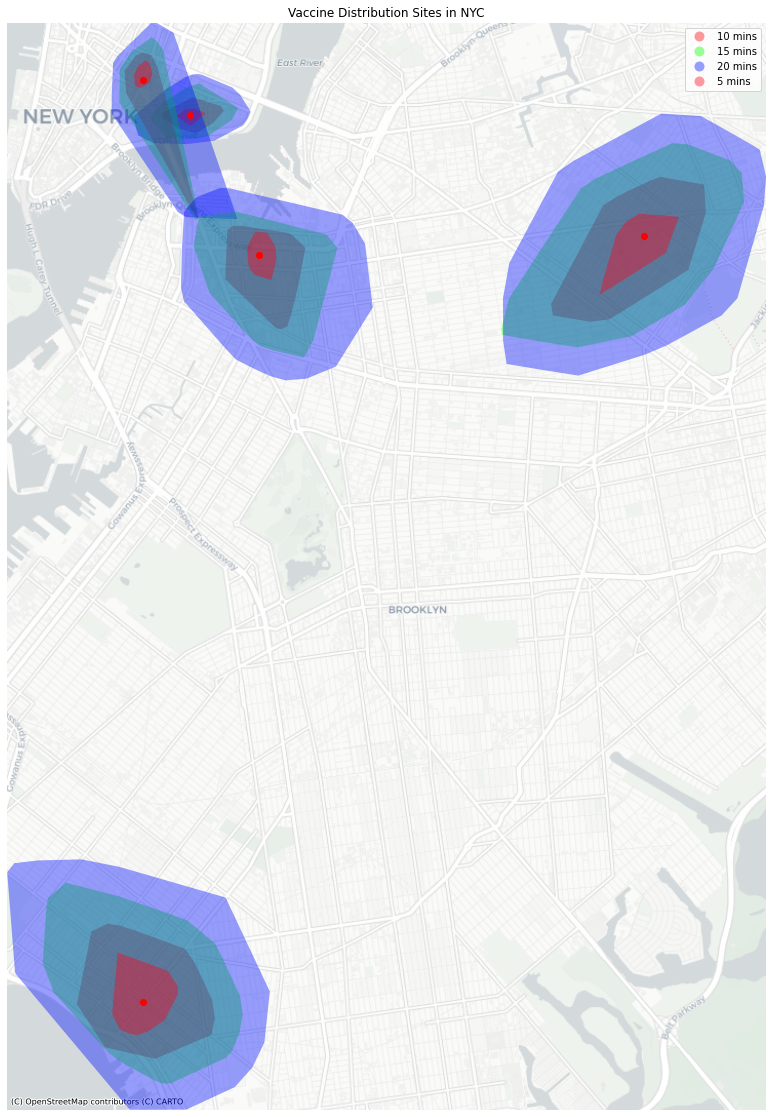

In [21]:
# set up the figure
fig, ax = plt.subplots(figsize=(20,20))

for i in range(len(vac)):
    nodes_name = "gdf_nodes" + str(i)
    
    iso_dummy = isochrones[nodes_name]
    nodes_dummy = nodes[nodes_name]

    # add the isochrones
    iso_dummy.plot(alpha=0.4, 
                    ax=ax, 
                    column='time', 
                    cmap='hsv', 
                    legend=True,
                    zorder=20)

    # add the center node in red
    nodes_dummy.loc[[cen_node[nodes_name]]].plot(ax=ax,color='r', zorder=30)


# hide the axis
ax.axis('off')
    
# scale to fit
ax.margins(0)

# give it a title
ax.set_title('Vaccine Distribution Sites in NYC')

# add the basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

WOW! It worked! Honestly, I'm shocked. It's a little ugly, but this will exercise be a great backbone for our projectl

# Notes

## Future Improvements

* Convert the 'improved method' of creating better isochrones to the `for` loop synatax to make more realistic walkshed areas. 
* Learn how to dissolve overlapping isochrones into each other to create a sort of walking heatmap for all vaccine distribution locations.
* Clean up naming conventions in the code for easier legibility. 

## Concerns

* Running this code with five locations results in several cells taking awhile to run (~30 seconds). Will this code work for 100+ locations? Does Jupyter Notebooks have enough memory to run that many? 
* Can I make my code more efficient in order to reduce memory usage? (ex. deleting dummy variables after they are created). Is the dictionary the most efficient data structure for this task? 
* Is reusing variables like "name" and "dummy" a bad practice? I want to streamline the code for legibility and efficiency but also don't want to create contradictions.

I will talk to Yoh in office hours about any improvements to this method and the feasibility of running the code on a larger dataset. 